Hunter Bennett | Glass Lab | Kupffer Strains Project | 07 February 2021

In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff
from gene_expression_plots import survey_strain_amln_gene_exp, survey_strain_ccl4_gene_exp

In [3]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/01_Strains_AMLN_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

###  Import differential peaks from last time

In [3]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/diff_output.txt',
    './merged_peaks/ann_norm_kc_control_atac_peaks_all.txt')

annotatePeaks all peaks (61711, 25)
getDiffExpression selected transcripts (60547, 33)
annotatePeaks selected peaks (60547, 25)


In [4]:
comp_dict = pull_comparisons_get_diff(diff_peak)

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


# Process for motif calling with Homer

For motif calling its unclear whether it would be ideal to take all peaks activated in C57 compared to any other strain and look for motif enrichment or whether it would be better to look at motifs only in a pairwise fashion. I probably lean towards looking at any peak activated in C57 since they should be enriched for strain specific motifs.

In [5]:
if not os.path.isdir('./motif_calling/'):
    os.mkdir('./motif_calling/')

Ty pointed out that running annotatePeaks.pl on a peak file adjusts the peak size to what is being annotated :O so we have to pull the original coordinates out of the ATAC file. The ATAC peak file from O'young's pipeline has an average peak size of about 270 so they are a little bigger than the NFR we like for ATAC seq. I'm unsure whether the best thing to do here would be to make them all 200 bp based on the center of the peak or if we should just use the merged peak sizes

# Correct merge-peaks shifting of atac peak files
Make atac peak file with 200bp peaks set on center of current peak (rounding down if fractional center)

In [6]:
atac_peaks = pd.read_csv('./merged_peaks/idr_peaks_merged.txt', sep='\t', index_col=0)

In [7]:
new_start = []
new_end = []
for index, row in atac_peaks.iterrows():
    center = row.start + int(np.floor((row.end - row.start)/2))
    new_start.append(center - 100)
    new_end.append(center + 100)
    
atac_peaks_200bp = atac_peaks.iloc[:, :4].copy(deep=True)
atac_peaks_200bp['start'] = new_start
atac_peaks_200bp['end'] = new_end
atac_peaks_200bp.index.rename('PeakID', inplace=True)

In [8]:
diff_peak_distal = diff_peak.loc[np.abs(diff_peak.loc[:, 'Distance to TSS'])>3000, :]
atac_peaks_200bp_distal = atac_peaks_200bp.reindex(diff_peak_distal.index).dropna(how='all')

# print to check that this worked
print(diff_peak.shape[0], 'peaks in differential peak file')
print(atac_peaks_200bp.shape[0], 'peaks in ATAC-seq file')
print()
print(diff_peak_distal.shape[0], 'distal peaks in differential peak file')
print(atac_peaks_200bp_distal.shape[0], 'distal peaks in ATAC-seq file')

60547 peaks in differential peak file
61711 peaks in ATAC-seq file

36392 distal peaks in differential peak file
36392 distal peaks in ATAC-seq file


# Extract target peaks

Set cutoffs

In [9]:
# initialize dict and list of cell types
peak_lists = {}
bg_lists = {}
cells = ['00_c57',
         '01_balbc',
         '02_aj']

# set pvalue and fc thresholds
fc = np.log2(2)
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)


        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'peaks')
        print('Intersection set at:', len(i), 'peaks\n')
     
    
        # store lists
        peak_lists[cell+'_union'] = u
        peak_lists[cell+'_intersection'] = i

Analyzing 00_c57 ...

0
For comp: 00_c57 vs. 01_balbc
Union set at: 3777 peaks
Intersection set at: 3777 peaks

1
For comp: 00_c57 vs. 02_aj
Union set at: 4864 peaks
Intersection set at: 1927 peaks

2
For comp: 01_balbc vs. 02_aj
Union set at: 4864 peaks
Intersection set at: 1927 peaks

Analyzing 01_balbc ...

0
For comp: 00_c57 vs. 01_balbc
Union set at: 2725 peaks
Intersection set at: 2725 peaks

1
For comp: 00_c57 vs. 02_aj
Union set at: 2725 peaks
Intersection set at: 2725 peaks

1
For comp: 01_balbc vs. 02_aj
Union set at: 3325 peaks
Intersection set at: 517 peaks

Analyzing 02_aj ...

0
For comp: 00_c57 vs. 01_balbc
Union set at: 3325 peaks
Intersection set at: 517 peaks

0
For comp: 00_c57 vs. 02_aj
Union set at: 2248 peaks
Intersection set at: 2248 peaks

1
For comp: 01_balbc vs. 02_aj
Union set at: 3208 peaks
Intersection set at: 249 peaks



# Save peaks for motif calling

In [10]:
convert_dict = {'start': int,
                'end': int}

In [11]:
for df, txt in zip([atac_peaks_200bp, atac_peaks_200bp_distal], ['', '_distal']):
    for key in peak_lists.keys():
        # save cell specific promoters
        tmp = df.reindex(peak_lists[key]).dropna(how='all')
        tmp = tmp.astype(convert_dict)
        tmp.to_csv('./motif_calling/'+key+'_act'+txt+'_peaks.txt',
                   sep='\t')
        
        # save specific background
        tmp = df.loc[df.index.difference(peak_lists[key]), :]
        tmp = tmp.astype(convert_dict)
        tmp.to_csv('./motif_calling/'+key+'_bg'+txt+'_peaks.txt',
                   sep='\t')


### Call motifs using homer

In [12]:
strain_dict = {'c57': 'c57bl6j',
               'balbc': 'balbcj',
               'aj': 'aj'}

In [13]:
with open('./findMotifs_homer.sh', 'w') as f:
    for peakfile in np.sort(glob.glob('./motif_calling/*act*')):
        strain = peakfile.split('/')[-1].split('_')[1]
        call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                peakfile, 'mm10', peakfile.replace('_peaks.txt', '_motifs').replace('_act', ''),
                '-bg', peakfile.replace('_act_', '_bg_'),
                '-len 8,10,12,14,16', '-fg_strain', strain_dict[strain],
                '-bg_strain', strain_dict[strain], '-p 12\n\n']
        f.write(' '.join(call))

# Aggregate results - Homer

In [14]:
glob.glob('./motif_calling/*motifs/knownResults.txt')

['./motif_calling/00_c57_intersection_distal_motifs/knownResults.txt',
 './motif_calling/02_aj_union_distal_motifs/knownResults.txt',
 './motif_calling/00_c57_union_distal_motifs/knownResults.txt',
 './motif_calling/02_aj_intersection_motifs/knownResults.txt',
 './motif_calling/01_balbc_intersection_motifs/knownResults.txt',
 './motif_calling/00_c57_union_motifs/knownResults.txt',
 './motif_calling/01_balbc_intersection_distal_motifs/knownResults.txt',
 './motif_calling/02_aj_intersection_distal_motifs/knownResults.txt',
 './motif_calling/01_balbc_union_motifs/knownResults.txt',
 './motif_calling/00_c57_intersection_motifs/knownResults.txt',
 './motif_calling/02_aj_union_motifs/knownResults.txt',
 './motif_calling/01_balbc_union_distal_motifs/knownResults.txt']

In [15]:
known_motif_pval_dict = {}
for f in np.sort(glob.glob('./motif_calling/*/knownResults.txt')):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[2]
    
    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame = known_motif_pval_frame.reindex(known_motif_pval_frame.mean(axis=1).sort_values().index.tolist())

known_motif_pval_frame.to_csv('./homer_known_motifs_log.txt', sep='\t')

# Plot known motif results

## Plot intersection motifs

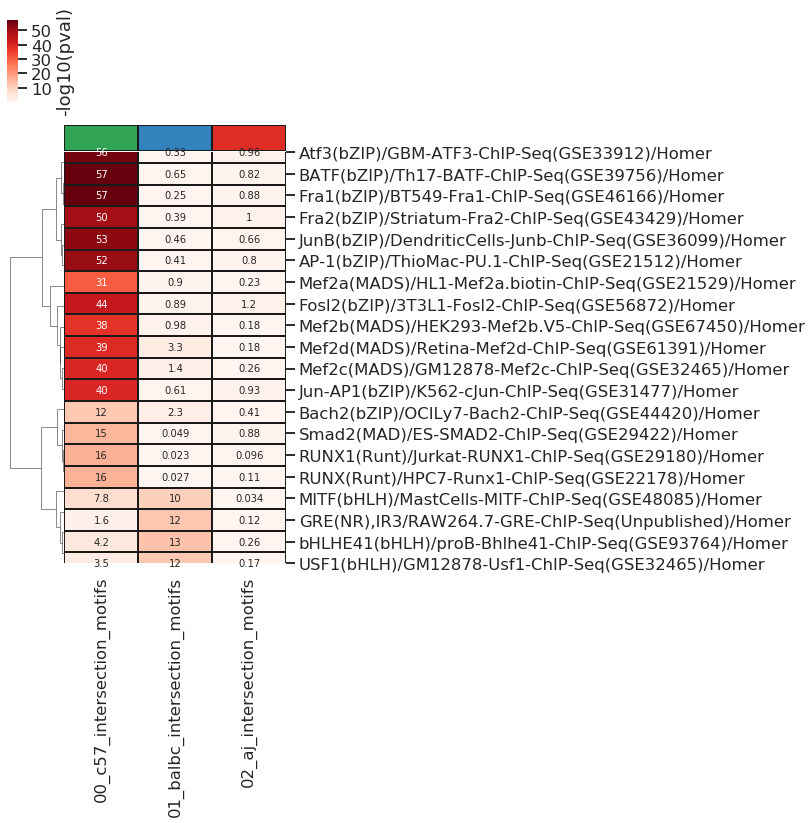

In [16]:
tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('intersection')]
tmp_frame = tmp_frame.loc[:, ~tmp_frame.columns.str.contains('distal')]

# sort by new mean
tmp_frame = tmp_frame.reindex(tmp_frame.mean(axis=1).sort_values(ascending=True).index.tolist())


sns.clustermap(
    -tmp_frame.loc[(known_motif_pval_frame <=-5).any(axis=1), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_intersection_enhancers.png',
            bbox_inches='tight')

### Select motifs with highest score difference

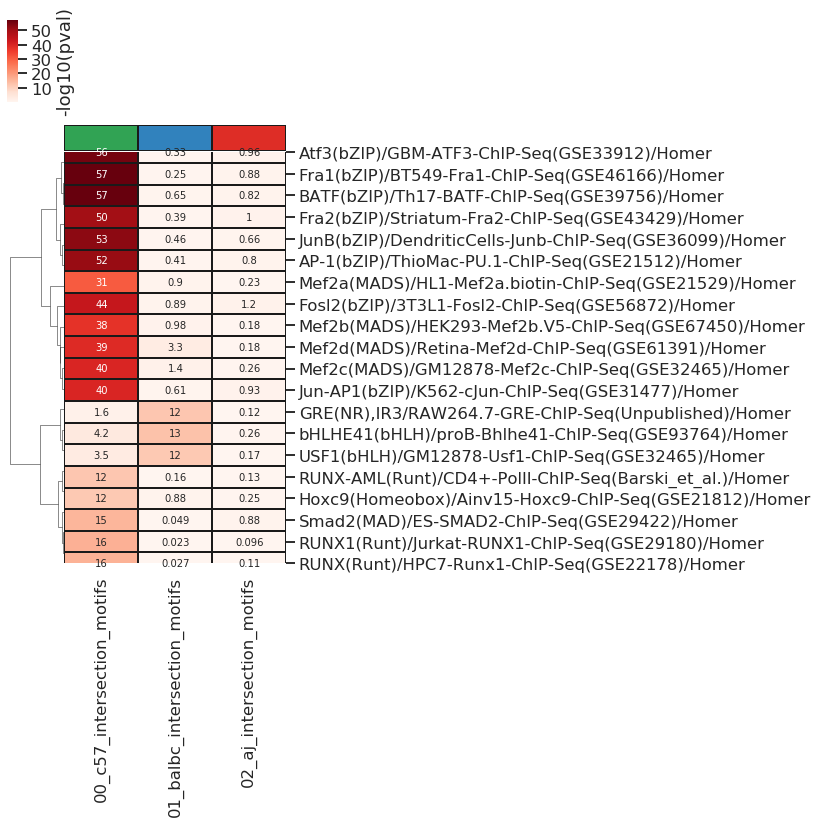

In [17]:
sns.clustermap(
    -tmp_frame.loc[(tmp_frame.max(1)-tmp_frame.min(1)).sort_values(ascending=False).index.tolist(), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_intersection_rankdiff_enhancers.png',
            bbox_inches='tight')

## Plot union motifs

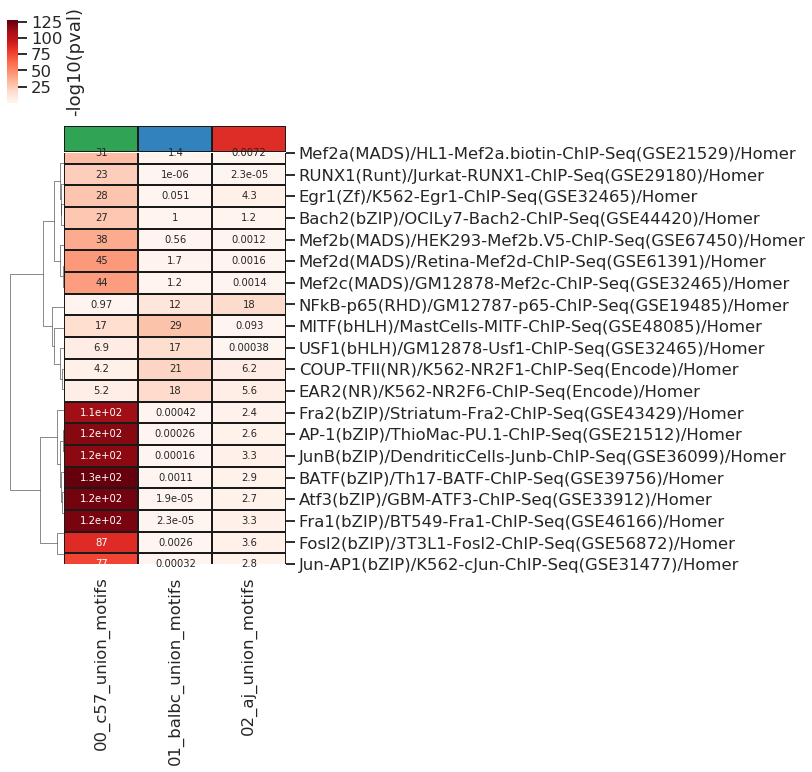

In [18]:
tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('union')]
tmp_frame = tmp_frame.loc[:, ~tmp_frame.columns.str.contains('distal')]

# sort by new mean
tmp_frame = tmp_frame.reindex(tmp_frame.mean(axis=1).sort_values(ascending=True).index.tolist())


sns.clustermap(
    -tmp_frame.loc[(known_motif_pval_frame <=-5).any(axis=1), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_union_enhancers.png',
            bbox_inches='tight')

### Select motifs with highest score difference

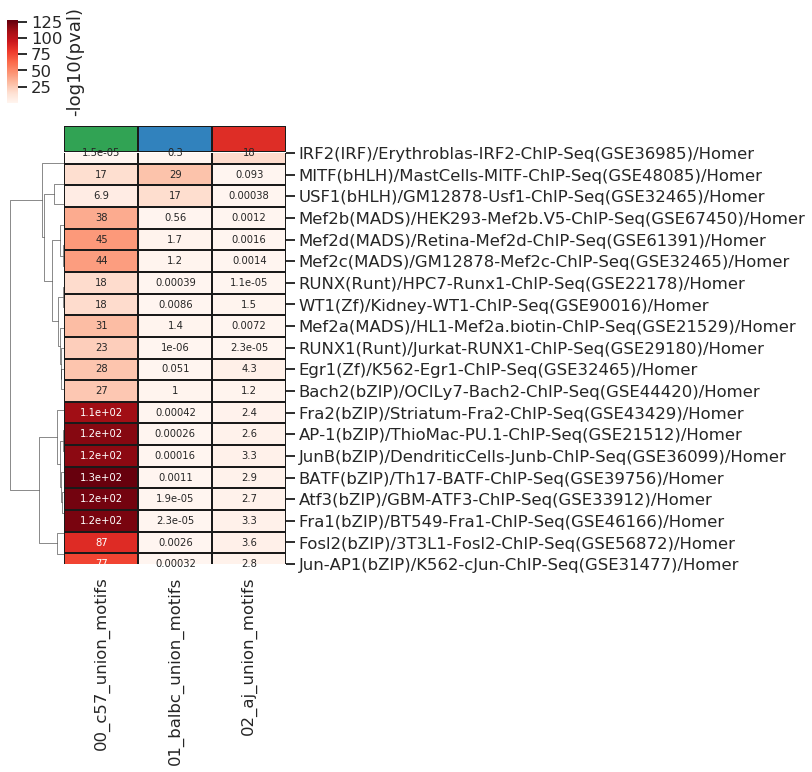

In [19]:
sns.clustermap(
    -tmp_frame.loc[(tmp_frame.max(1)-tmp_frame.min(1)).sort_values(ascending=False).index.tolist(), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_union_rankdiff_enhancers.png',
            bbox_inches='tight')

# Distal motifs

## Plot intersection distal motifs

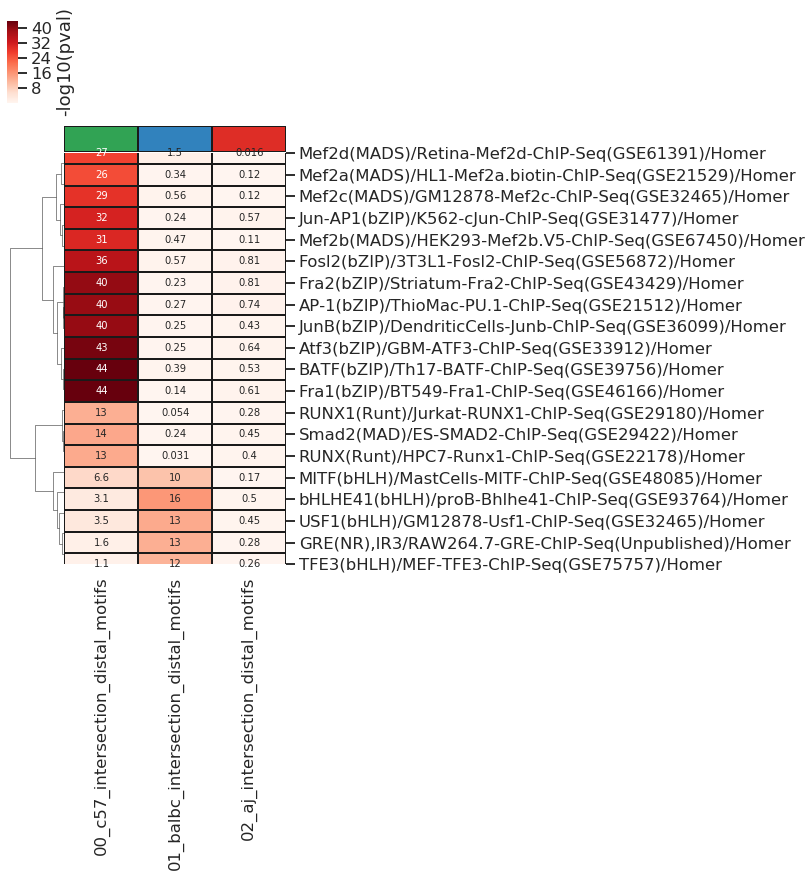

In [20]:
tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('intersection')]
tmp_frame = tmp_frame.loc[:, tmp_frame.columns.str.contains('distal')]

# sort by new mean
tmp_frame = tmp_frame.reindex(tmp_frame.mean(axis=1).sort_values(ascending=True).index.tolist())


sns.clustermap(
    -tmp_frame.loc[(known_motif_pval_frame <=-5).any(axis=1), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_intersection_distal_enhancers.png',
            bbox_inches='tight')

### Select motifs with highest score difference

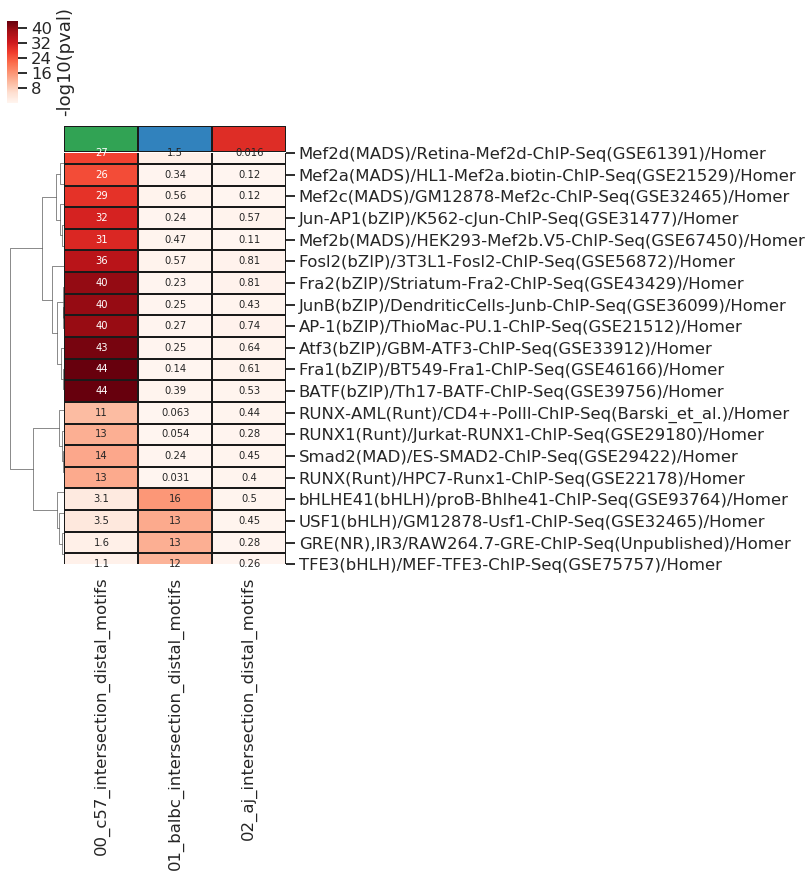

In [21]:
sns.clustermap(
    -tmp_frame.loc[(tmp_frame.max(1)-tmp_frame.min(1)).sort_values(ascending=False).index.tolist(), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_intersection_rankdiff_distal_enhancers.png',
            bbox_inches='tight')

## Plot union distal motifs

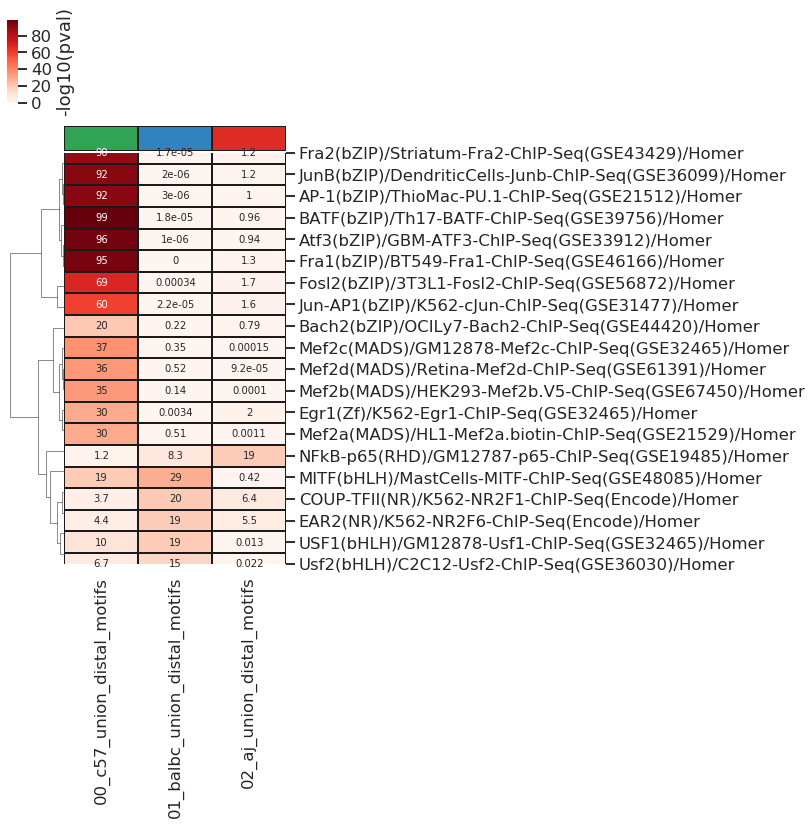

In [22]:
tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('union')]
tmp_frame = tmp_frame.loc[:, tmp_frame.columns.str.contains('distal')]

# sort by new mean
tmp_frame = tmp_frame.reindex(tmp_frame.mean(axis=1).sort_values(ascending=True).index.tolist())


sns.clustermap(
    -tmp_frame.loc[(known_motif_pval_frame <=-5).any(axis=1), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_union_distal_enhancers.png',
            bbox_inches='tight')

### Select motifs with highest score difference

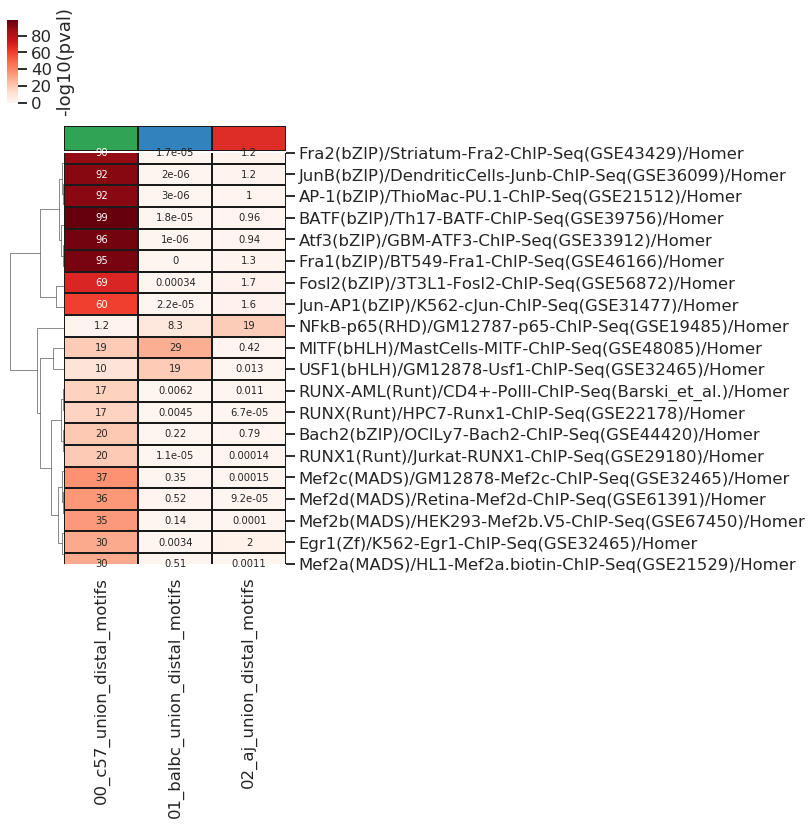

In [23]:
sns.clustermap(
    -tmp_frame.loc[(tmp_frame.max(1)-tmp_frame.min(1)).sort_values(ascending=False).index.tolist(), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(5,10))

plt.savefig('./figures/known_motif_strain_specific_union_rankdiff_distal_enhancers.png',
            bbox_inches='tight')

# Summarize motifs with O'young's script
___
this isn't actually all that useful.

In [1]:
header = ['motif', 'col', 'known', 'denovo']
path = ['/home/h1bennet/strains/results/01_Strains_AMLN_H3K27Ac/motif_calling/00_c57_intersection_distal_motifs']
col = ['#2ca25f']
knownmotifs = ['3,9,10,20']
denovomotifs = ['1,2,4,8']

In [12]:
if not os.path.isdir('./motif_plots/'):
    os.mkdir('./motif_plots/')

In [20]:
plot_motif_test = pd.DataFrame([path, col, knownmotifs, denovomotifs], index=header).T
plot_motif_test.to_csv('./motif_plots/plotMotifTest.txt', sep='\t', index=False)